Here we will have a look at our dataset. Then will process it and have create the train, test and validation sets.  
First lets load the data

In [19]:
import pandas as pd

df_hour = pd.read_csv('./dataset/hour.csv')
df_day = pd.read_csv('./dataset/day.csv')

print(df_hour.shape)

df_hour.head()


(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
df_hour.insert(1,'ds', pd.to_datetime(df_hour['dteday']) + pd.to_timedelta(df_hour['hr'], unit='h'))
df_hour = df_hour.drop(['instant','dteday','yr','mnth'],axis=1)
df_hour.head()

,ds,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01 00:00:00,1,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [21]:
df_hour['unique_id'] = 'bike_sharing'  


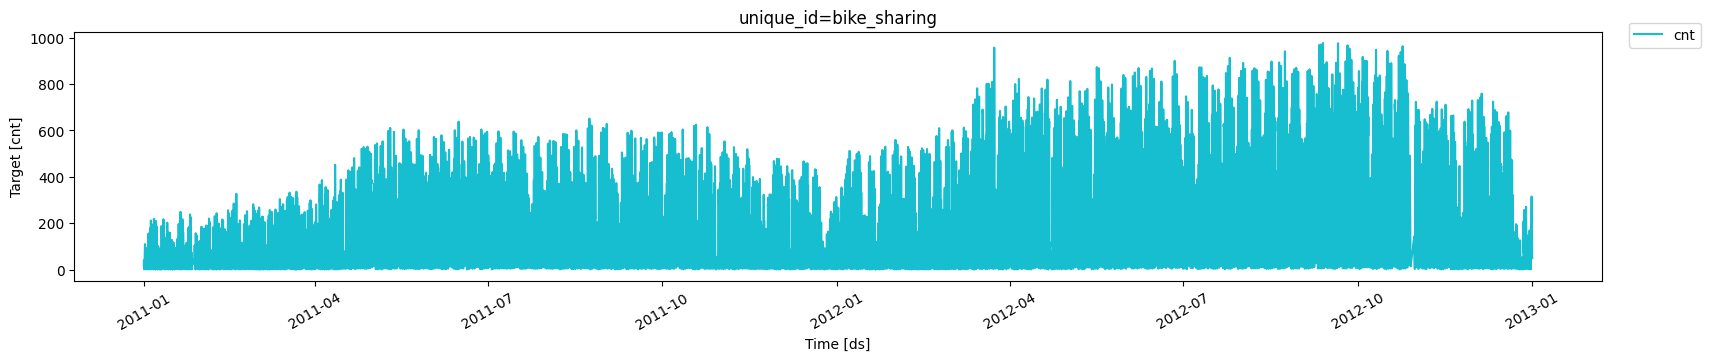

In [22]:
from utilsforecast.plotting import plot_series

plot_series(df=df_hour, time_col='ds', target_col='cnt' )

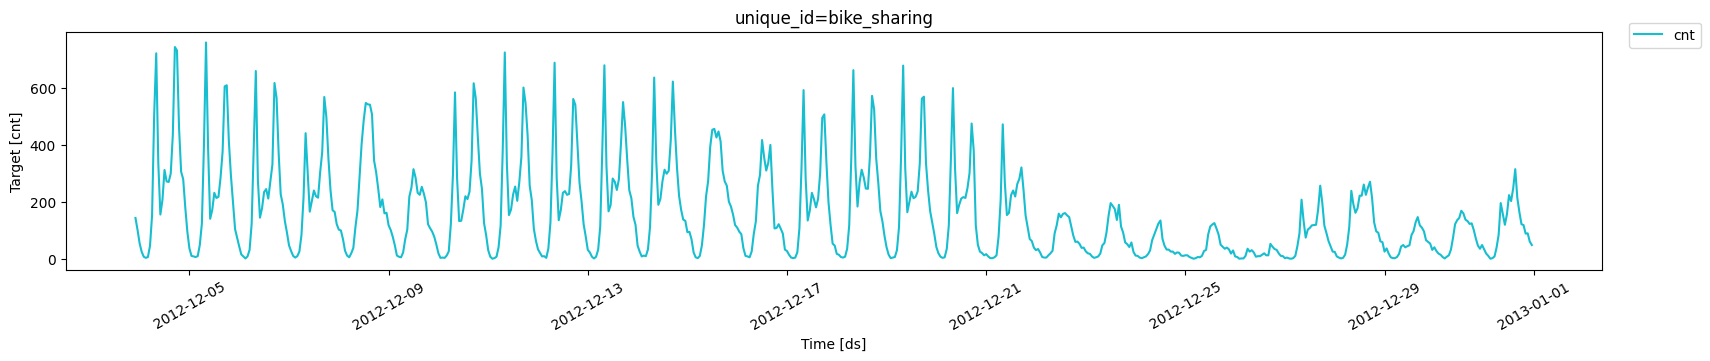

In [23]:
plot_series(df=df_hour, time_col='ds', target_col='cnt', max_insample_length=24*28 )

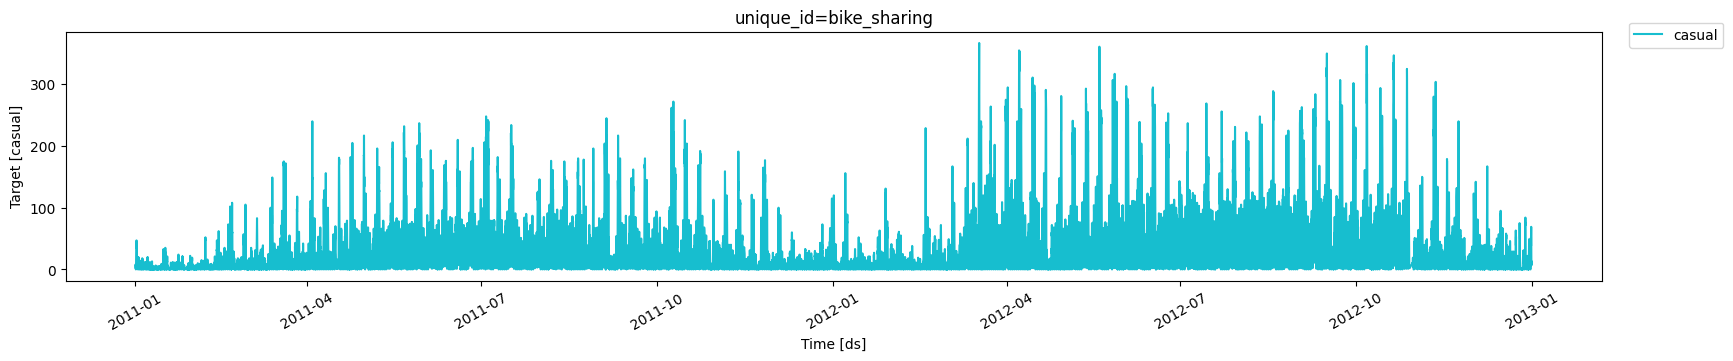

In [24]:
plot_series(df=df_hour, time_col='ds', target_col='casual' )

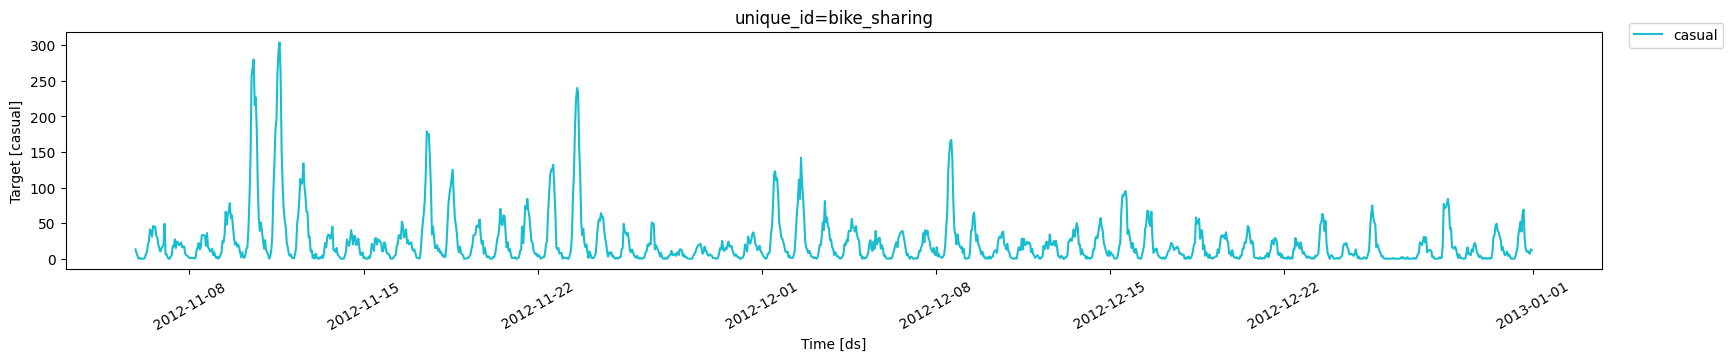

In [28]:
plot_series(df=df_hour, time_col='ds', target_col='casual', max_insample_length=24*56 )

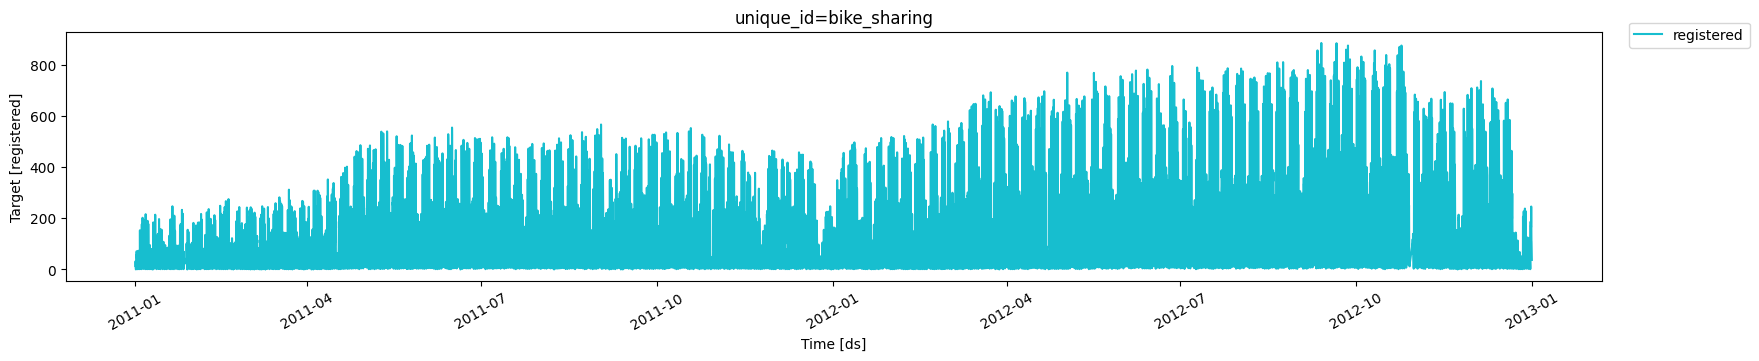

In [26]:
plot_series(df=df_hour, time_col='ds', target_col='registered' )

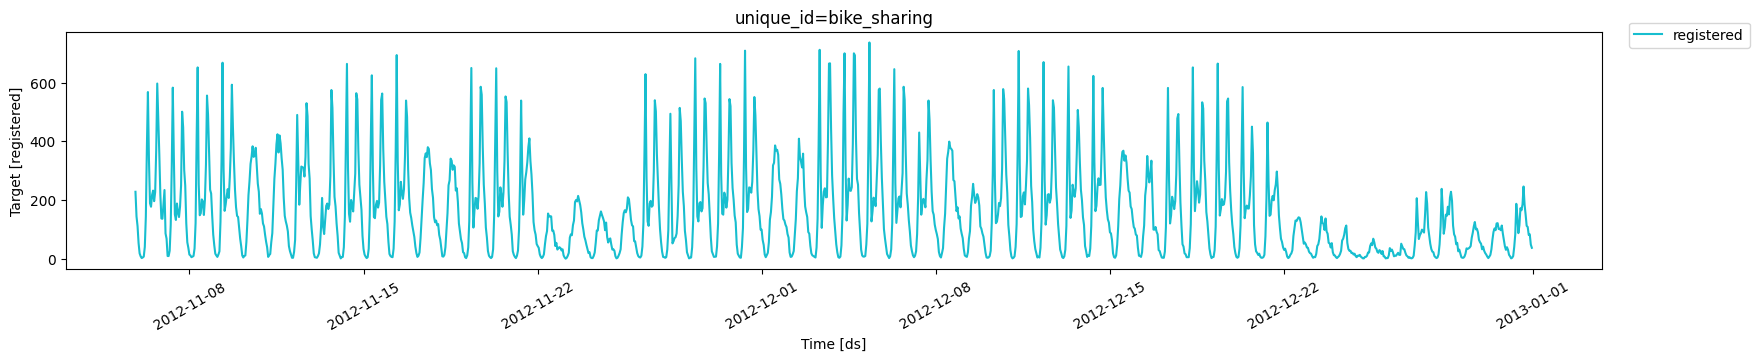

In [29]:
plot_series(df=df_hour, time_col='ds', target_col='registered', max_insample_length=24*56 )

We can clearly see a daily seasonality and weekly seasonality here. Here I will develop the model to predict registed and casual users seperately as both groups have a pattern but different from each other.

In [ ]:
# Let's add addtitional features by applying sin and cos for achive daily and weekly seasonalities
import numpy as np
import datetime

timestamp_s = pd.to_datetime(df_hour['ds']).map(datetime.datetime.timestamp)

day = 24*60*60

df_hour['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values    # maintaining cyclic nature
df_hour['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values    

df_hour['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values    # maintaining cyclic nature
df_hour['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values 

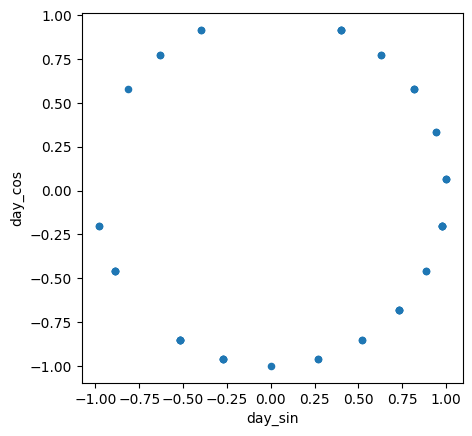

In [ ]:
df_hour = df_hour.drop(['ds', 'holiday', 'weekday'], axis=1)

df_hour.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal')

In [17]:
print(df_hour.drop(['unique_id'],axis=1).corr())

              season   holiday   weekday  workingday  weathersit      temp  \
season      1.000000 -0.009585 -0.002335    0.013743   -0.014524  0.312025   
holiday    -0.009585  1.000000 -0.102088   -0.252471   -0.017036 -0.027340   
weekday    -0.002335 -0.102088  1.000000    0.035955    0.003311 -0.001795   
workingday  0.013743 -0.252471  0.035955    1.000000    0.044672  0.055390   
weathersit -0.014524 -0.017036  0.003311    0.044672    1.000000 -0.102640   
temp        0.312025 -0.027340 -0.001795    0.055390   -0.102640  1.000000   
atemp       0.319380 -0.030973 -0.008821    0.054667   -0.105563  0.987672   
hum         0.150625 -0.010588 -0.037158    0.015688    0.418130 -0.069881   
windspeed  -0.149773  0.003988  0.011502   -0.011830    0.026226 -0.023125   
casual      0.120206  0.031564  0.032721   -0.300942   -0.152628  0.459616   
registered  0.174226 -0.047345  0.021578    0.134326   -0.120966  0.335361   
cnt         0.178056 -0.030927  0.026900    0.030284   -0.142426

In [18]:
df_hour.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
season,17379.0,2.501640,1.106918,1.000000,2.000000,3.000000e+00,3.000000,4.000000
holiday,17379.0,0.028770,0.167165,0.000000,0.000000,0.000000e+00,0.000000,1.000000
weekday,17379.0,3.003683,2.005771,0.000000,1.000000,3.000000e+00,5.000000,6.000000
workingday,17379.0,0.682721,0.465431,0.000000,0.000000,1.000000e+00,1.000000,1.000000
weathersit,17379.0,1.425283,0.639357,1.000000,1.000000,1.000000e+00,2.000000,4.000000
temp,17379.0,0.496987,0.192556,0.020000,0.340000,5.000000e-01,0.660000,1.000000
atemp,17379.0,0.475775,0.171850,0.000000,0.333300,4.848000e-01,0.621200,1.000000
hum,17379.0,0.627229,0.192930,0.000000,0.480000,6.300000e-01,0.780000,1.000000
windspeed,17379.0,0.190098,0.122340,0.000000,0.104500,1.940000e-01,0.253700,0.850700
casual,17379.0,35.676218,49.305030,0.000000,4.000000,1.700000e+01,48.000000,367.000000
